In [160]:
%load_ext autoreload
%autoreload 2
    
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt
from torch.ao.quantization import QConfig, HistogramObserver, MinMaxObserver


prompt = "A cat is sitting, looking out the window"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
input_image = None
image_path = "./images/dog.jpg"
input_image = Image.open(image_path).convert('RGB')

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.1

## SAMPLER
num_inference_steps = 50
seed = 42
model = StableDiffusion(model_type='txt2img')
loaded_state_dict = load_weights_from_ckpt('./weights/model/v1-5-pruned-emaonly.ckpt', device='cpu')
model.vae.load_state_dict(loaded_state_dict['vae'], strict=True)
model.unet.load_state_dict(loaded_state_dict['unet'], strict=True)
model.cond_encoder.load_state_dict(loaded_state_dict['cond_encoder'], strict=True)

tokenizer = CLIPTokenizer('./weights/tokenizer/tokenizer_vocab.json', merges_file='./weights/tokenizer/tokenizer_merges.txt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
%load_ext autoreload
%autoreload 2
output_image = model.generate(
    input_image=None,
    img_size=(512, 512),
     prompt="A cozy mountain cabin at sunrise",
     uncond_prompt=uncond_prompt,
     do_cfg=do_cfg,
     cfg_scale=cfg_scale,
     device='cpu',
     strength=0.2,
     inference_steps=num_inference_steps,
     sampler='ddpm',
     use_cosine_schedule=False,
     seed=seed,
     tokenizer=tokenizer
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████| 50/50 [05:18<00:00,  6.37s/it]


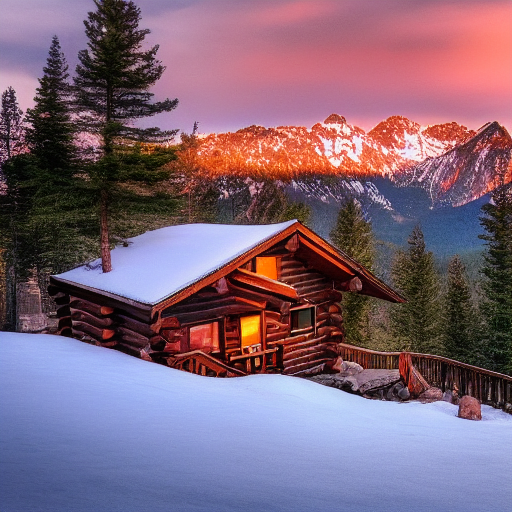

In [182]:
Image.fromarray(output_image)

In [101]:
%load_ext autoreload
%autoreload 2
    
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt
from torch.ao.quantization import QConfig, HistogramObserver, MinMaxObserver


cond = [[0, 0, 0, 0, 1]]
uncond = [[0, 0, 0, 0, 0]]   # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
input_image = None
image_path = "./images/image_6.JPEG"
input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.1

## SAMPLER
num_inference_steps = 50
seed = 42
model = StableDiffusion(model_type='class2img', num_classes=5)
loaded_state_dict = torch.load('./weights/model/stable_diffusion_epoch_25.ckpt', map_location='cpu')['model_state_dict']
model.load_state_dict(loaded_state_dict)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<All keys matched successfully>

In [102]:
%load_ext autoreload
%autoreload 2

output_image = model.generate_img_from_given_class(
    input_image=input_image,
    img_size=(16, 16),
    cond=[[0, 0, 0, 0, 1]],
     uncond=[[0, 0, 0, 0, 0]],
     do_cfg=False,
     cfg_scale=cfg_scale,
     device='cpu',
     strength=1.0,
     inference_steps=num_inference_steps,
     sampler='ddim',
     use_cosine_schedule=False,
     seed=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.79it/s]


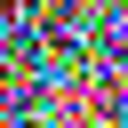

In [99]:
output_image.resize((128, 128))

In [184]:
%load_ext autoreload
%autoreload 2
!python3 train.py --device=mps --batch_size 32 --data_dir ./data/sprites/ --save_dir ./checkpoints/ --checkpoint_dir ./checkpoints/ --pretrained ./weights/model/stable_diffusion_epoch_25.ckpt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  0%|                                                  | 0/2235 [00:00<?, ?it/s]tensor([666, 520, 901, 689,  81, 505, 203, 246, 545, 677, 186, 264,  49, 141,
        809, 938, 585, 293, 820, 878, 774, 873, 981, 603, 266, 119, 974, 995,
        884, 611, 385, 910], device='mps:0')

Step [0/2235] | Loss: 0.1099
  0%|                                       | 1/2235 [00:29<18:01:49, 29.06s/it]tensor([877, 389, 810, 985, 518, 653, 514,   5, 431, 690,  45, 329, 260, 729,
        178, 685, 742, 430, 369, 213, 353, 541, 589, 360, 985, 376, 374, 339,
        504, 231, 998, 884], device='mps:0')
  0%|                                       | 2/2235 [01:11<22:50:08, 36.82s/it]tensor([868, 170, 725, 570, 350, 697, 671, 368, 778, 942, 157, 512, 438, 552,
        948,  11, 157, 990, 112, 637,  23, 813, 678, 331, 287,   8, 648, 109,
        847, 855,  80, 769], device='mps:0')
^C
